<a href="https://colab.research.google.com/github/9-coding/PyTorch/blob/main/10-view_data_detach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# view, data, and detach

In [1]:
import torch
import matplotlib.pyplot as plt

print(torch.__version__)

2.2.1+cu121


In [2]:
def get_tensor_info(tensor):
  info = []
  for name in ['requires_grad', 'is_leaf', 'retains_grad', 'grad_fn', 'grad']:
    info.append(f'{name}({getattr(tensor, name, None)})')
  info.append(f'\ntensor{str(tensor)}')
  return ' '.join(info)

## tensor.view()
**tensor 인스턴스의 dimension 수정에 사용.**
- 원본 tensor 인스턴스 데이터가 contiguous해야 함.
- 이 메서드는 새로운 shape를 가진 같은 데이터의 새로운 tensor 인스턴스를 반환하지만, 원본 tensor 인스턴스와 underlying memory를 공유하여 같은 데이터를 공유함.
- 즉, 메모리를 재할당하지 않고 tensor의 shape와 각 축의 stride만이 바뀜.

In [4]:
# requires_grad=True는 이 텐서에 대한 연산을 추적해야 함을 의미
a = torch.rand(12,requires_grad=True)
print(f'{a.shape=}, {a.data_ptr()=}, \n{a.is_contiguous()=}, {a.stride()=}\n')

a_view = a.view((2,3,2))
print(f'a_view: {a_view.shape=}, {a_view.data_ptr()=}, \n{a_view.is_contiguous()=}, {a_view.stride()=}\n')

a_view_t = a_view.transpose(0,1)
print(f'a_view_t: {a_view_t.shape=}, {a_view_t.data_ptr()=}, \n{a_view_t.is_contiguous()=}, {a_view_t.stride()=}\n')

a_other = a_view_t.contiguous()
print(f'a_other: {a_other.shape=}, {a_other.data_ptr()=}, \n{a_other.is_contiguous()=}, {a_other.stride()=}')


a.shape=torch.Size([12]), a.data_ptr()=99936652987264, 
a.is_contiguous()=True, a.stride()=(1,)

a_view: a_view.shape=torch.Size([2, 3, 2]), a_view.data_ptr()=99936652987264, 
a_view.is_contiguous()=True, a_view.stride()=(6, 2, 1)

a_view_t: a_view_t.shape=torch.Size([3, 2, 2]), a_view_t.data_ptr()=99936652987264, 
a_view_t.is_contiguous()=False, a_view_t.stride()=(2, 6, 1)

a_other: a_other.shape=torch.Size([3, 2, 2]), a_other.data_ptr()=99936668387008, 
a_other.is_contiguous()=True, a_other.stride()=(4, 2, 1)


## tensor.data
**tensor 인스턴스의 데이터를 의미하는 attribute.**<br>
tensor 인스턴스의 grad와 requires_grad와 같은 tensor의 메타데이터를 가지고 있지 않은 순수한 데이터를 의미.
- 주로 autograd에서 미분 계산을 하지 않고 원본 데이터를 직접 조작할 때 사용.
- 현재 tensor.data를 직접 접근하는 방식은 권장되지 않음.


## tensor.detach
- .detach()를 사용하여 계산 그래프에서 해당 텐서를 분리하면 gradient 계산에서 제외되나 여전히 데이터는 공유함.
- tensor.data를 직접 수정할 경우, 계산 그래프의 무결성이 깨질 수 있으며 이는 예상치 못한 버그의 원인이 됨.

직접적인 데이터 조작이 필요할 때는 계산 그래프에서 해당 텐선 인스턴스를 분리하는 .detach() 사용 권장

In [5]:

b = a*2.        #
b.retain_grad() # leaf tensor가 아닌데도 grad를 확인하기 위해서 호출.

c = b*3.        #
c.retain_grad() # leaf tensor가 아닌데도 grad를 확인하기 위해서 호출.

# .detach()를 사용하여 c 에서 더 이상 그래디언트가 전파되지 않도록 처리.
c_detach = c.detach()
# u 는 이제 그래디언트 계산에서 제외.
# u 를 사용한 추가 연산도 수행 가능
u = c_detach*2.  # u의 계산은 그래디언트 추적에서 제외됩니다.

# 그러나 c에 대한 추가 연산은 detach되지않은 다른 tensor의 경우처럼 c의 gradient 계산에 영향.
# 즉, c에 대해 또 다른 연산을 추가하고, 그 연산에 대한 gradient를 계산함.
d = c * 2.
d.retain_grad() # leaf tensor가 아닌데도 grad를 확인하기 위해서 호출.

# d 에 대한 gradient를 계산.
print('------------')
d.backward(torch.ones(d.shape))


print(a.grad) # 12
print(b.grad) # 6
print(c.grad) # 2
print(d.grad) # 1

# leaf이 아닌 tensor들에 대한 gradient를 보려면, retain_grad() 를 사용.
for c_tensor in [a,b,c,d]:
  c_grad = c_tensor.grad
  if c_grad != None:
    c_grad.zero_()


------------
tensor([12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.])
tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.])
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


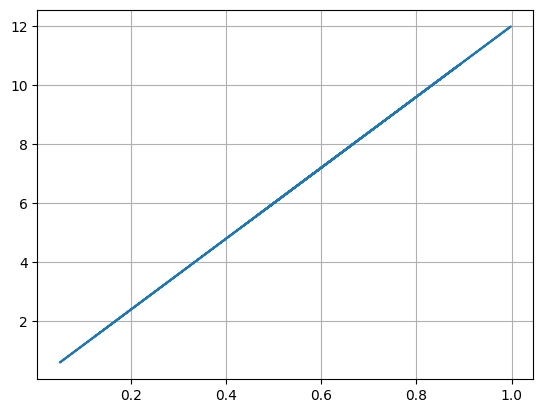

In [6]:
# require_grad 기능을 켠 tensor는 일반적인 numpy 객체를 얻거나 matplotflib에서 사용할 수 없으나 detach를 사용하면 가능.
a_detach = a.detach().numpy() # a와 여전히 underlying memory를 공유.
d_detach = d.detach().numpy() # b와 여전히 underlying memory를 공유.

fig, axis = plt.subplots(1,1)
axis.plot(a_detach,d_detach)
axis.grid()
# axis.set_xlim(a_detach.min(),a_detach.max())
# axis.set_ylim(d_detach.min(),d_detach.max())

In [7]:
c_detach[0] = 100
print(c) # c도 변경됨.

# underlying memory같음을 확인.
print(c.data_ptr())
print(c.detach().data_ptr())


tensor([100.0000,   5.9892,   2.7832,   5.3149,   0.3057,   1.1633,   3.9697,
          4.0123,   3.6654,   2.9263,   5.3548,   0.7452],
       grad_fn=<MulBackward0>)
99936591759296
99936591759296


In [8]:
for cur in [a,b,c,d]:
  print(get_tensor_info(cur))
  print('------------------')

requires_grad(True) is_leaf(True) retains_grad(False) grad_fn(None) grad(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])) 
tensortensor([0.4348, 0.9982, 0.4639, 0.8858, 0.0509, 0.1939, 0.6616, 0.6687, 0.6109,
        0.4877, 0.8925, 0.1242], requires_grad=True)
------------------
requires_grad(True) is_leaf(False) retains_grad(True) grad_fn(<MulBackward0 object at 0x7cb3b8862500>) grad(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])) 
tensortensor([0.8696, 1.9964, 0.9277, 1.7716, 0.1019, 0.3878, 1.3232, 1.3374, 1.2218,
        0.9754, 1.7849, 0.2484], grad_fn=<MulBackward0>)
------------------
requires_grad(True) is_leaf(False) retains_grad(True) grad_fn(<MulBackward0 object at 0x7cb3b8862500>) grad(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])) 
tensortensor([100.0000,   5.9892,   2.7832,   5.3149,   0.3057,   1.1633,   3.9697,
          4.0123,   3.6654,   2.9263,   5.3548,   0.7452],
       grad_fn=<MulBackward0>)
------------------
requires_grad(True) i